# Plant Species Classification

The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has released a dataset containing images of unique plants belonging to 12 species at several growth stages.

The ability to differentiate between a weed and a crop seedling can mean better crop yields and better stewardship of the environment.

# Data:
- **Labels.csv:** Total 12 unique values.
- **images.npy:** Each value in these columns is between 0 and 255. Which represents the pixel intensity. 

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.1'

In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential          
from tensorflow.keras.layers import Conv2D              
from tensorflow.keras.layers import MaxPooling2D       
from tensorflow.keras.layers import Flatten             
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab.patches import cv2_imshow

from sklearn import svm
from sklearn.model_selection import train_test_split

## Loading the data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images = np.load('./drive/MyDrive/images.npy')
images.shape

(4750, 128, 128, 3)

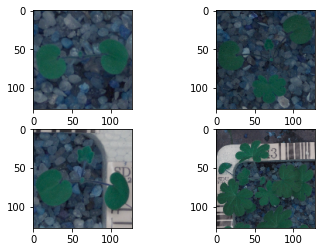

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(images[0])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(images[1])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(images[2])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(images[3])

In [ ]:
SEED=123
LABELS = "./drive/MyDrive/Labels.csv"
data = pd.read_csv(LABELS)
data.shape

(4750, 1)

In [ ]:
Y = data.Label
Y

0       Small-flowered Cranesbill
1       Small-flowered Cranesbill
2       Small-flowered Cranesbill
3       Small-flowered Cranesbill
4       Small-flowered Cranesbill
                  ...            
4745             Loose Silky-bent
4746             Loose Silky-bent
4747             Loose Silky-bent
4748             Loose Silky-bent
4749             Loose Silky-bent
Name: Label, Length: 4750, dtype: object

In [ ]:
labels = data.Label.unique()
labels

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

# Data Pre-processing


Original Image:



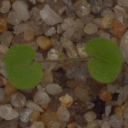

In [ ]:
print('Original Image:\n')
cv2_imshow(images[0])

In [ ]:
for i in range(len(images)):
    images[i] = cv2.GaussianBlur(images[i], (15, 15), 0)


 After gaussian blurring: 



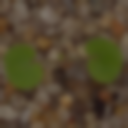

In [ ]:
print('\n After gaussian blurring: \n')
cv2_imshow(images[0])

In [ ]:
# Normalize the data
X = images.astype('float32') / 255.0

# Make data compatible


In [ ]:
labels_dict =  {0:'Black-grass', 1:'Charlock', 2:'Cleavers', 3:'Common Chickweed', 4:'Common wheat', 5:'Fat Hen', 6:'Loose Silky-bent', 7:'Maize', 8:'Scentless Mayweed', 9:'Shepherds Purse', 10:'Small-flowered Cranesbill', 11:'Sugar beet'}

In [ ]:
# Convert categorical values to dummy values
Y = pd.get_dummies(Y)
Y

,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4745,0,0,0,0,0,0,1,0,0,0,0,0
4746,0,0,0,0,0,0,1,0,0,0,0,0
4747,0,0,0,0,0,0,1,0,0,0,0,0
4748,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Convert labels to one hot vectors.

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
Y = enc.fit_transform(Y)
Y

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X.shape

(4750, 128, 128, 3)

In [ ]:
Y.shape

(4750, 12)

In [ ]:
# The data split:

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

first_label_train = y_train[0].tolist()
index_first = first_label_train.index(1)
labels_dict[index_first]

'Maize'

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3325, 128, 128, 3)
(3325, 12)
(712, 128, 128, 3)
(712, 12)


# Build CNN


In [ ]:
# CNN model

model = models.Sequential()

model.add(layers.Conv2D(128, (5, 5), padding='same', activation="relu", input_shape=(128, 128, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(256, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(256, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(500, activation="relu"))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(12, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 128)     9728      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 256)       819456    
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 256)       1024      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 256)      

In [ ]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [ ]:
# train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

# Modelling and Evaluation

In [217]:
history = model.fit(x_train,
                    y_train,
                    batch_size=256,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    shuffle=True,
                    verbose=1,
                    callbacks=[model_checkpoint])

Epoch 1/100
13/13 [==============================] - 11s 864ms/step - loss: 0.0327 - accuracy: 0.9913 - val_loss: 0.4510 - val_accuracy: 0.9101

Epoch 00001: val_loss did not improve from 0.31501
Epoch 2/100
13/13 [==============================] - 11s 862ms/step - loss: 0.0267 - accuracy: 0.9919 - val_loss: 0.4737 - val_accuracy: 0.9073

Epoch 00002: val_loss did not improve from 0.31501
Epoch 3/100
13/13 [==============================] - 11s 872ms/step - loss: 0.0277 - accuracy: 0.9895 - val_loss: 0.5313 - val_accuracy: 0.8624

Epoch 00003: val_loss did not improve from 0.31501
Epoch 4/100
13/13 [==============================] - 11s 869ms/step - loss: 0.0316 - accuracy: 0.9922 - val_loss: 0.4776 - val_accuracy: 0.8975

Epoch 00004: val_loss did not improve from 0.31501
Epoch 5/100
13/13 [==============================] - 11s 856ms/step - loss: 0.0366 - accuracy: 0.9901 - val_loss: 0.5097 - val_accuracy: 0.8975

Epoch 00005: val_loss did not improve from 0.31501
Epoch 6/100
13/13 [=

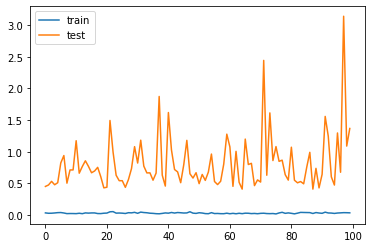

In [218]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [219]:
# Score trained model.
scores = model.evaluate(x_val, y_val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 1s 30ms/step - loss: 1.2849 - accuracy: 0.8359
Test loss: 1.2848973274230957
Test accuracy: 0.8359046578407288


# Predictions

### Prediction for x_test[2]

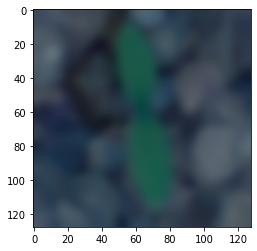

In [220]:
plt.imshow(x_test[2])

In [221]:
test_image = np.expand_dims(x_test[2], axis = 0)                
test_image = test_image * 1/255.0

y_pred = model.predict(test_image)

# predict class with maximum probability
y_pred = np.argmax(y_pred, axis=1)

pred_name = labels_dict[np.argmax(y_pred)]
print(pred_name)

Black-grass


### Prediction for x_test[3]

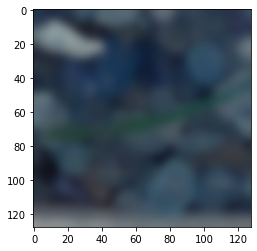

In [222]:
plt.imshow(x_test[3])

In [223]:
test_image1 = np.expand_dims(x_test[3], axis = 0)                
test_image1 = test_image1 * 1/255.0

y_pred = model.predict(test_image1)

# predict class with maximum probability
y_pred = np.argmax(y_pred, axis=1)

pred_name = labels_dict[np.argmax(y_pred)]
print(pred_name)

Black-grass


### Prediction for x_test[33]

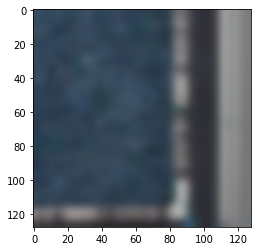

In [224]:
plt.imshow(x_test[33])

In [225]:
test_image2 = np.expand_dims(x_test[33], axis = 0)                
test_image2 = test_image2 * 1/255.0

y_pred = model.predict(test_image2)

# predict class with maximum probability
y_pred = np.argmax(y_pred, axis=1)

pred_name = labels_dict[np.argmax(y_pred)]
print(pred_name)

Black-grass


### Prediction for x_test[36]

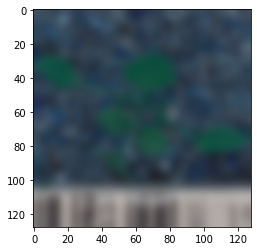

In [226]:
plt.imshow(x_test[36])

In [227]:
test_image3 = np.expand_dims(x_test[36], axis = 0)                
test_image3 = test_image3 * 1/255.0

y_pred = model.predict(test_image3)

# predict class with maximum probability
y_pred = np.argmax(y_pred, axis=1)

pred_name = labels_dict[np.argmax(y_pred)]
print(pred_name)

Black-grass


### Prediction for x_test[59]

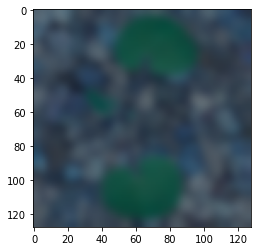

In [228]:
plt.imshow(x_test[59])

In [229]:
test_image4 = np.expand_dims(x_test[59], axis = 0)                
test_image4 = test_image4 * 1/255.0

y_pred = model.predict(test_image4)

# predict class with maximum probability
y_pred = np.argmax(y_pred, axis=1)

pred_name = labels_dict[np.argmax(y_pred)]
print(pred_name)

Black-grass
